# Convolutional Neural Networks

<style>
img {
    display: block;
    margin-left: auto;
    margin-right: auto;
    padding: 5px;
}

figcaption {
  font-style: italic;
  padding: 2px;
  text-align: center;
}

</style>

 <figure>
  <img src="img/cnn_banner.webp" alt="Software 2.0" width="70%">
  <figcaption>CNN</figcaption>
</figure>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F

print(torch.__version__)
torch.cuda.is_available()

2.8.0+cu126


True

In [3]:
# trans = transforms.Compose([
#     transforms.RandomCrop([128, 128]),
#     transforms.ToTensor()])


trans_train = transforms.Compose([
        transforms.RandomResizedCrop(160),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

trans_val = transforms.Compose([
        transforms.Resize(180),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [4]:
training_data = datasets.Imagenette(
    root="data",
    split="train",
    size="160px",
    download=True,
    transform=trans_train,
)

# Download test data from open datasets.
test_data = datasets.Imagenette(
    root="data",
    split="val",
    size="160px",
    download=True,
    transform=trans_val,
)

In [5]:
training_data

Dataset Imagenette
    Number of datapoints: 9469
    Root location: data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(160, 160), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
training_data.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [7]:
first_image, first_label = training_data[10]

In [8]:
first_image.shape, first_label

(torch.Size([3, 160, 160]), 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9306722..2.5528543].


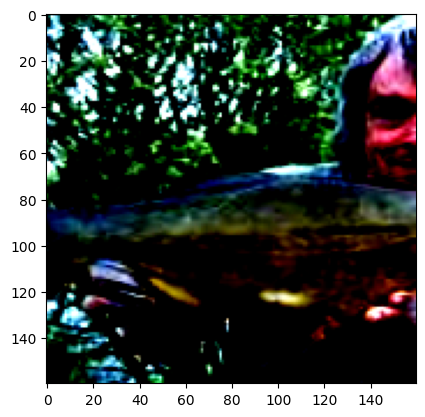

In [9]:
import matplotlib.pyplot as plt
import numpy as np

"""
Deep learning libraries like PyTorch and TensorFlow typically use channels-first format (C, H, W) for image tensors, while matplotlib expects channels-last format (H, W, C). The transpose operation rearranges the dimensions to make the tensor compatible with matplotlib's expectations.
"""

plt.imshow(np.transpose(first_image, (1, 2, 0)))

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)  # Force to 5x5
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [11]:
model = SimpleCNN()
print(model)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(5, 5))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
batch_size = 64

# Create data loaders.
train_dl = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(test_data, batch_size=batch_size)

In [13]:
for b in train_dl:
    print(b[0].shape, b[1])
    break

torch.Size([64, 3, 160, 160]) tensor([0, 1, 9, 9, 6, 2, 7, 0, 3, 2, 5, 6, 7, 6, 9, 4, 2, 6, 7, 5, 9, 2, 4, 4,
        7, 1, 1, 5, 7, 1, 0, 8, 5, 8, 0, 6, 4, 3, 2, 8, 5, 9, 9, 5, 1, 3, 5, 1,
        6, 2, 1, 2, 8, 8, 4, 6, 4, 8, 0, 9, 7, 3, 4, 3])


In [14]:
from training_utils import train, plot_hist, evaluate

In [15]:
num_epochs = 10
hist = train(model, num_epochs, train_dl, val_dl)

Epoch 1: train_acc: 0.2407 val_acc: 0.3279 train_loss: 2.0811 val_loss: 1.8947
Epoch 2: train_acc: 0.3508 val_acc: 0.4245 train_loss: 1.8588 val_loss: 1.6821
Epoch 3: train_acc: 0.4092 val_acc: 0.4938 train_loss: 1.7301 val_loss: 1.5250
Epoch 4: train_acc: 0.4491 val_acc: 0.5330 train_loss: 1.6447 val_loss: 1.4148
Epoch 5: train_acc: 0.4734 val_acc: 0.5276 train_loss: 1.5708 val_loss: 1.4216
Epoch 6: train_acc: 0.4852 val_acc: 0.5646 train_loss: 1.5502 val_loss: 1.3242
Epoch 7: train_acc: 0.5006 val_acc: 0.5982 train_loss: 1.4931 val_loss: 1.2624
Epoch 8: train_acc: 0.5057 val_acc: 0.6015 train_loss: 1.4855 val_loss: 1.2416
Epoch 9: train_acc: 0.5179 val_acc: 0.6056 train_loss: 1.4458 val_loss: 1.2060
Epoch 10: train_acc: 0.5344 val_acc: 0.6250 train_loss: 1.4143 val_loss: 1.1700


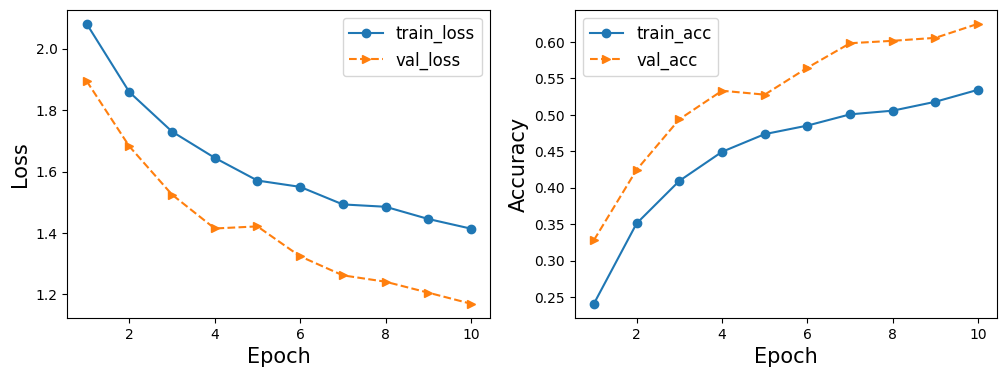

In [16]:
plot_hist(hist)

With pretrained models we can do it better